In [40]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)

### Create the data

In [7]:
torch.manual_seed(seed=1234)
N = 200 # num_samples_per_class
D = 2 # dimensions
C = 3 # num_classes

In [71]:
X = torch.zeros((N*C, D))
y = torch.zeros((N*C)).int()
for i in range(C):
    index = 0
    r = torch.linspace(0, 1, N)
    t = torch.linspace(i*4,(i+1)*4,N) + torch.randn(N)*0.1
    for ix in range(N*i, N*(i+1)):
        X[ix] = torch.FloatTensor(
            (r[index]*np.sin(t[index]), r[index]*np.cos(t[index])), )
        y[ix] = i
        index += 1

print ("SHAPES:")
print ("-------------------")
print ("X:", X.size())
print ("y:", y.size())    

SHAPES:
-------------------
X: torch.Size([600, 2])
y: torch.Size([600])


In [77]:
def plot_data(X, y):
    """
    Plot the data.
    """
    plt.scatter (X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.cool)
    plt.show ()

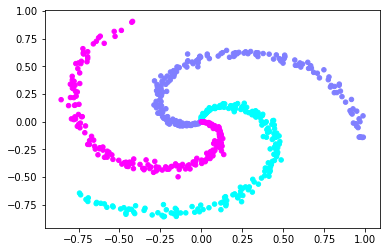

In [78]:
# Create the data
plot_data(X.numpy(), y.numpy())